In [1]:
# Set up packages for lecture. Don't worry about understanding this code,
# but make sure to run it if you're following along.
import numpy as np
import babypandas as bpd
import pandas as pd
from matplotlib_inline.backend_inline import set_matplotlib_formats
import matplotlib.pyplot as plt
set_matplotlib_formats("png")
plt.style.use('ggplot')

np.set_printoptions(threshold=20, precision=2, suppress=True)
pd.set_option("display.max_rows", 7)
pd.set_option("display.max_columns", 8)
pd.set_option("display.precision", 2)

def draw_cutoff(results):
    ax = bpd.DataFrame().assign(results=results).plot(kind='hist', bins=np.arange(160, 240, 4), 
                                             density=True, figsize=(10, 5),
                                             title='Empirical Distribution of the Number of Heads in 400 Flips of a Fair Coin')
    for bar in ax.containers[0]:
        x = bar.get_x() + 0.5 * bar.get_width()
        if x < 184:
            bar.set_color('#796fb3')
    plt.annotate('likely biased\ntowards tails', (160, 0.007), size=16, color='#796fb3', weight='bold')
    plt.annotate('likely fair', (225, 0.008), size=16, color='#e24a33', weight='bold');

# Lecture 21 – Hypothesis Testing and Total Variation Distance

## DSC 10, Fall 2023

### Announcements

- Homework 5 is due **tomorrow at 11:59PM**.
- Lab 6 is due **Monday 11/27 at 11:59PM**.
- Happy Thanksgiving! 🦃
    - There will be lecture and discussion section on Wednesday as usual, but there is no quiz. 
    - There will be no office hours on Thursday, Friday, or Saturday. 

### Final Project released,  due **Tuesday 12/5 at 11:59PM**
- In the project, you'll explore data from NASA about meteorites. You'll look at where meteorites landed and where they were seen falling, and explore whether there is any relationship between these locations and the locations where people tend to live. For example, here are the places where meteorites have been seen falling.
<center><img src="images/meteorites.jpg" width=60%></center>
- If you want to work with a partner, follow [these guidelines](https://dsc10.com/project-partners/) and get started soon!

### Agenda

- Example: Is our coin fair?
    - p-values and conventions for consistency.
- Example: Midterm scores.
    - Does this sample look like it was drawn from this population?
- Example: Jury selection in Alameda County.
    - Total variation distance.

## Example: Is our coin fair?

### Example: Is our coin fair?

Last time we looked at an example where we found a coin on the ground, flipped it 400 times, and used the results to determine whether the coin was likely fair.

In [2]:
# The results of our 400 flips.
flips_400 = bpd.read_csv('data/flips-400.csv')
flips_400.groupby('outcome').count()

,flip
outcome,
Heads,188
Tails,212


**Question**: Does our coin look like a fair coin, or not?<br>
<small>How "weird" is it to flip a fair coin 400 times and see only 188 heads?</small>

### Stating the hypotheses

- The **hypotheses** describe two views of how our data was generated.
    - Remember, the null hypothesis needs to be a well-defined probability model about how the data was generated, so that we can use it for simulation. 

- One pair of hypotheses is:
    - **Null Hypothesis:** The coin is fair.
    - **Alternative Hypothesis:** The coin is not fair.

- A different pair is:
    - **Null Hypothesis:** The coin is fair.
    - **Alternative Hypothesis:** The coin is biased towards tails.

### Choosing a test statistic

- We plan to simulate 400 flips of a fair coin, many times, and keep track of a single number, called a **test statistic**, each time.

- Our test statistic should be chosen such that **high observed values lean towards one hypothesis and low observed values lean towards the other**. <br>
<small>The purpose of a test statistic is to help you distinguish between the two hypotheses.</small>

### Example test statistics

- When choosing between "the coin is fair" and "the coin is not fair", we might select $|\text{number of heads} - 200 |.$

<center><img src="images/abs.jpg" width=60%></center>

-  When choosing between "the coin is fair" and "the coin is biased towards tails," we might select $\text{number of heads}.$

<center><img src="images/num_heads.jpg" width=60%></center>

### Rough guidelines for choosing a test statistic

The test statistic you choose depends heavily on the pair of hypotheses you are testing. That said, these general guidelines may help.

- If the alternative hypothesis is of the form “A > B” or "A < B", then the test statistic should measure a difference and should not contain an absolute value.

- If the alternative hypothesis is of the form “A and B are different”, then the test statistic should measure distance and should contain an absolute value.

### Simulating under the null

- Once we have stated our hypotheses and chosen an appropriate test statistic, we repeatedly generate samples under the assumption that the null hypothesis is true and record the value of the test statistic for each generated sample. <br>
<small> Here, we'll repeatedly flip a fair coin 400 times. </small>

- **Suppose we're choosing between "the coin is fair" and "the coin is biased towards tails".** <br>
<small> Here, our test statistic is the number of heads in 400 flips. </small>
 

In [3]:
# Computes a single simulated test statistic.
np.random.multinomial(400, [0.5, 0.5])[0]

194

In [4]:
# Computes 10,000 simulated test statistics.

results = np.array([])
for i in np.arange(10000):
    result = np.random.multinomial(400, [0.5, 0.5])[0]
    results = np.append(results, result)
    
results

array([206., 205., 191., ..., 201., 211., 200.])

### Visualizing the empirical distribution of the test statistic

Let's visualize the empirical distribution of the test statistic $\text{number of heads}$.

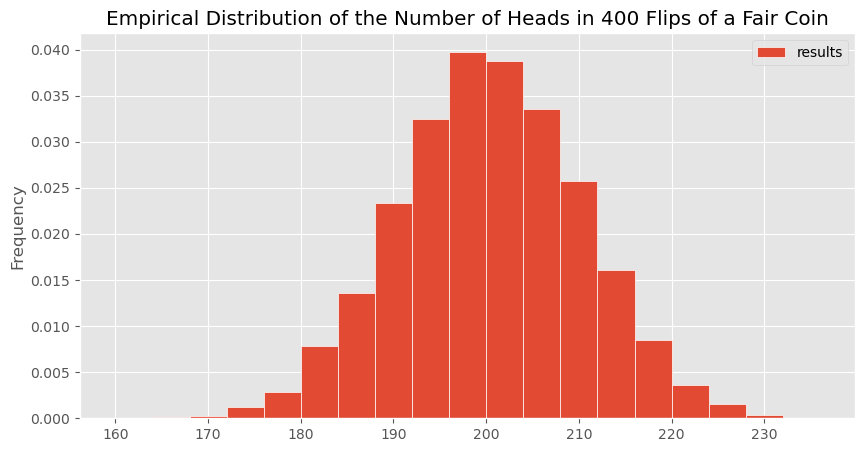

In [5]:
bpd.DataFrame().assign(results=results).plot(kind='hist', bins=np.arange(160, 240, 4), 
                                             density=True, ec='w', figsize=(10, 5),
                                             title='Empirical Distribution of the Number of Heads in 400 Flips of a Fair Coin');
plt.legend();

- Our hypothesis test boils down to checking **whether our observed statistic is a "typical value" in the distribution of our test statistic.**
    - If we see a small number of heads, we'll **reject the null hypothesis** in favor of the alternative hypothesis, "the coin is biased towards tails." 
    - Otherwise we'll **fail to reject the null hypothesis** because it's plausible that "the coin is fair."

- **Question:** Where do we draw the line between rejecting the null and failing to reject the null? How many heads, exactly, is considered a small number of heads?

### Determining a cutoff

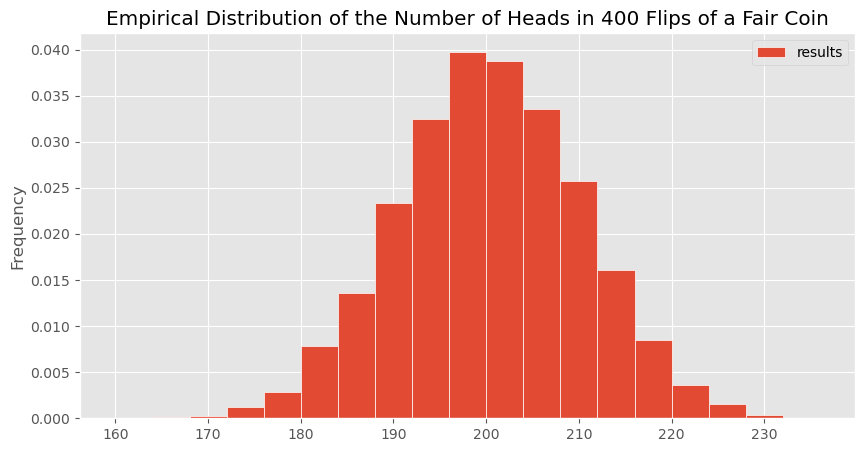

In [6]:
bpd.DataFrame().assign(results=results).plot(kind='hist', bins=np.arange(160, 240, 4), 
                                             density=True, ec='w', figsize=(10, 5),
                                             title='Empirical Distribution of the Number of Heads in 400 Flips of a Fair Coin');
plt.legend();

- The lower the number of heads we observe, the stronger the evidence for the alternative hypothesis, "the coin is biased towards tails."

- If we were to observe, say, 170 heads, even though such a result *could* happen with a fair coin, seeing 170 heads from a fair coin is sufficiently rare that we'd think the coin was biased towards tails. 

- If we were to observe, say, 195 heads, such a result happens frequently enough from a fair coin that we would not have good reason to think the coin was unfair.

- Let's say an outcome is **sufficiently rare** if it falls in the lowest **five percent** of outcomes in our simulation under the assumptions of the null hypothesis.
    - Five percent could be something else - five is just a nice round number. 

### Determining a cutoff

- We can determine the boundary between the lowest five percent of outcomes and the remaining outcomes using the concept of percentile.

In [7]:
np.percentile(results, 5)

184.0

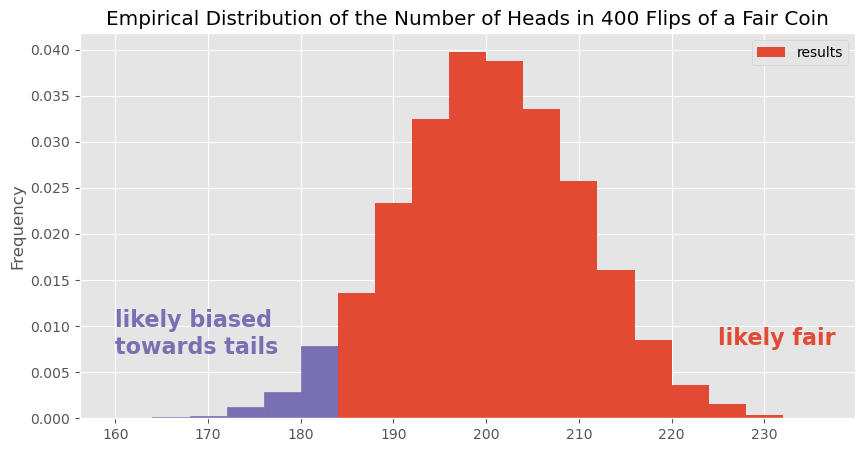

In [8]:
draw_cutoff(results)

- Now we have a clear cutoff that tells us which hypothesis to side with.
    - If we find a coin, flip it 400 times, and observe less than 184 heads, we'll side with "the coin is biased towards tails."
    - If we find a coin, flip it 400 times, and observe 184 heads or more, we'll side with "the coin is fair."

- The cutoff is somewhat arbitrary - we chose 5% but we could have chosen another number. 5% is a standard convention.

### p-values

- To quantify how rare our observed statistic is, under the null hypothesis, we can compute what’s called a **p-value**.

- The p-value is defined as the probability, under the null hypothesis, that the test statistic **is equal** to the value that was observed in the data **or is even further in the direction of the alternative**. <br>
<small>Its formal name is the observed significance level.</small>

- p-values correspond to the "tail areas" of a histogram, starting at the observed statistic.

### p-values

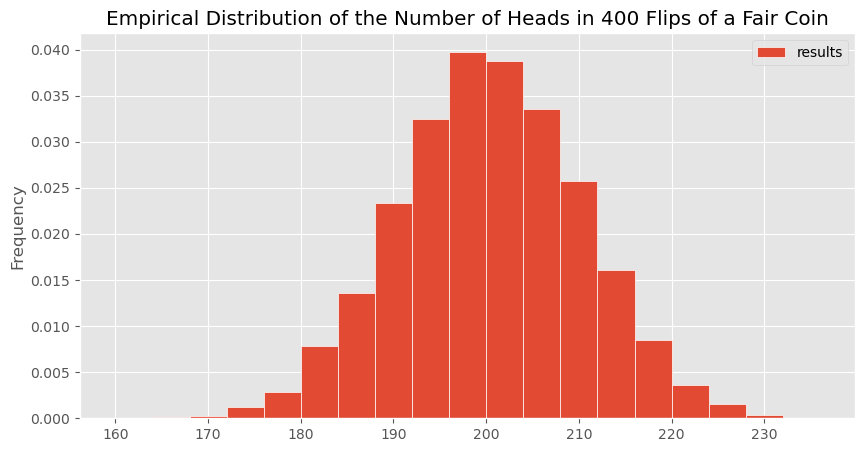

In [9]:
bpd.DataFrame().assign(results=results).plot(kind='hist', bins=np.arange(160, 240, 4), 
                                             density=True, ec='w', figsize=(10, 5),
                                             title='Empirical Distribution of the Number of Heads in 400 Flips of a Fair Coin');
plt.legend();

- For example, it's extremely rare to flip a fair coin 400 times and see 170 heads or fewer.

In [10]:
np.count_nonzero(results <= 170) / len(results)

0.0014

- But it's much less rare to flip a fair coin 400 times and see 195 heads or fewer.

In [11]:
np.count_nonzero(results <= 195) / len(results)

0.3275

- The larger the p-value, the more likely our observation is, if the null hypothesis is true. Therefore, 
    - Larger p-values mean we should fail to reject the null.
    - Smaller p-values mean we should reject the null.

### Conventions

- If the p-value is sufficiently large, we say the data is **consistent** with the null hypothesis and so we "**fail to reject the null hypothesis**".
    - We never say that we "accept" the null hypothesis! The null hypothesis may be plausible, but there are many other possible explanations for our data.

- If the p-value is below some cutoff, we say the data is **inconsistent** with the null hypothesis, and we **"reject the null hypothesis"**.
    - If a p-value is less than 0.05, the result is said to be "statistically significant".
    - If a p-value is less than 0.01, the result is said to be "highly statistically significant".
    - These conventions are historical and completely arbitrary! (And controversial.)

### Drawing a conclusion

- Recall that we found a coin, flipped it 400 times, and saw 188 heads. This is the **observed statistic**.

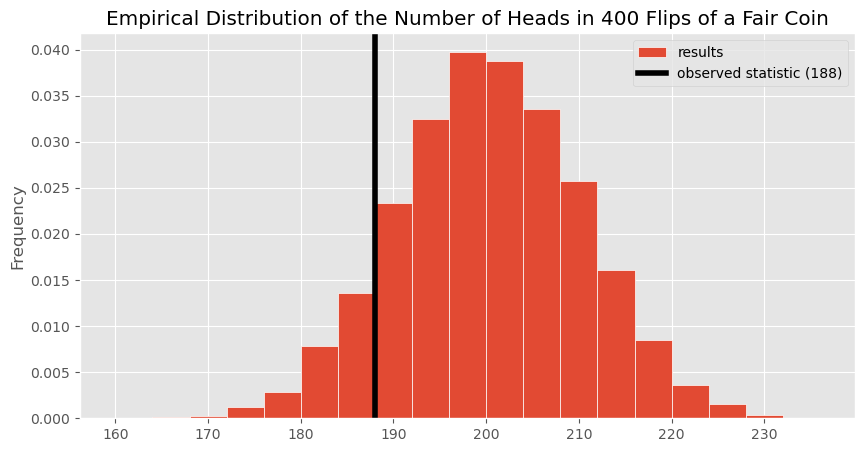

In [12]:
bpd.DataFrame().assign(results=results).plot(kind='hist', bins=np.arange(160, 240, 4), 
                                             density=True, ec='w', figsize=(10, 5),
                                             title='Empirical Distribution of the Number of Heads in 400 Flips of a Fair Coin');
plt.axvline(188, color='black', linewidth=4, label='observed statistic (188)')
plt.legend();

- How common is it to see 188 heads or fewer when we flip a fair coin 400 times? Let's calculate the p-value.

In [13]:
np.count_nonzero(results <= 188) / len(results)

0.1258

- It happens about 12% of the time. It's not so rare. Since the p-value is at least 0.05, we **fail to reject** the null hypothesis at the standard 0.05 **significance level** and conclude that it's plausible that our coin is fair.

### But was the coin we found really fair?

- Unfortunately, we'll never know. 🤷‍♂️ 

- But we can be assured that with a cutoff of 0.05, if the null hypothesis is actually true, we will incorrectly reject it only about 5% of the time. 

- In this way, we can interpret our p-value cutoff as a probability of error.

### Left or right? 👈👉

- In this example, we calculated the p-value as the area in the **left** tail of the histogram.

- But other times, when large values of the observed statistic indicate the alternative hypothesis, the p-value corresponds to the area in the **right** tail. 

- In order to calculate a p-value, we have to know whether larger or smaller values correspond to the alternative hypothesis. 

- We always calculate a p-value with `>=` or `<=` because it includes the probability that the test statistic exactly equals the observed statistic.

## Example: Midterm exam scores

### The problem

- In Fall 2022, there were four sections of DSC 10 – A, B, C, and D.

- One of the four sections – the one taught by Suraj – had a much lower average than the other three sections.
    - All midterms were graded by the same people, with the same rubrics.

In [14]:
# Midterm scores from DSC 10, Fall 2022, slightly perturbed for anonymity.
scores = bpd.read_csv('data/fa22-midterm-scores.csv')
scores

,Section,Score
0,A,54.5
1,D,62.0
2,B,23.5
...,...,...
390,C,62.5
391,B,47.5
392,D,72.5


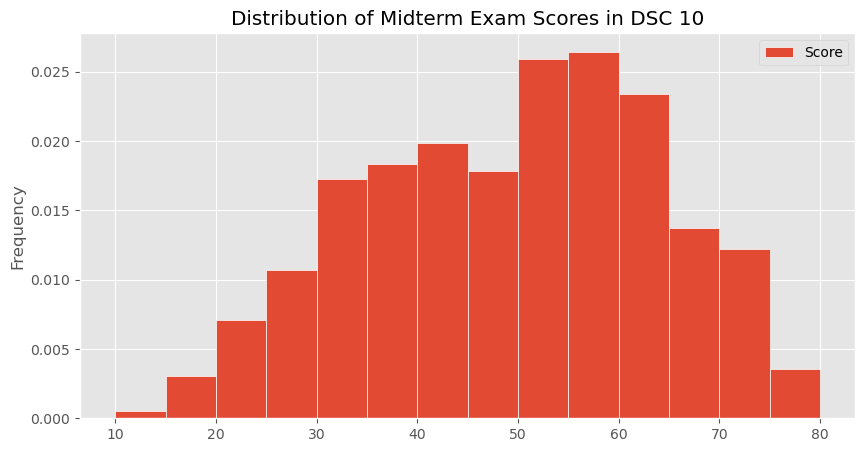

In [15]:
scores.plot(kind='hist', density=True, figsize=(10, 5), ec='w', bins=np.arange(10, 85, 5), title='Distribution of Midterm Exam Scores in DSC 10');

In [16]:
# Total number of students who took the exam.
scores.shape[0]

393

In [17]:
# Calculate the number of students in each section.
scores.groupby('Section').count()

,Score
Section,
A,117
B,115
C,108
D,53


In [18]:
# Calculate the average midterm score in each section.
scores.groupby('Section').mean()

,Score
Section,
A,51.54
B,49.48
C,46.17
D,50.88


<details>
    <summary>Click <b>here</b> to see Suraj's reaction 😱.</summary>
    <center><img src="images/surprise.png" width=25%></center>
</details>

### Thought experiment 💭🧪

- Suppose we _randomly_ place all 393 students into one of four sections and compute the average midterm score within each section. 

- One of the sections would _have to_ have a lower average score than the others (unless multiple are tied for the lowest).
    - In any set of four numbers, one of them has to be the minimum!

- But is Section C's average _lower_ than we'd expect due to chance? Let's perform a hypothesis test!

### Suraj's defense

- **Null Hypothesis:** Section C's scores are drawn randomly from the distribution of scores in the course overall. The observed difference between the average score in Section C and the average score in the course overall is due to random chance.

- **Alternative Hypothesis:** Section C's average score is too low to be explained by chance alone.




### Does this sample look like it was drawn from this population?

- This hypothesis test, like others we have seen, can be framed as a question of whether a certain sample (Suraj's section) appears to have been drawn randomly from a certain population (all students). 

- For the Robert Swain jury example, we asked if our sample of jury panelists looked like it was drawn from the population of eligible jurors.

- Even the fair coin example can be posed in this way. 
    - In this case, the population distribution is the uniform distribution (50% heads, 50% tails), and when we flip a coin, we are sampling from this distribution with replacement. 
    - We wanted to know if the sample of coin flips we observed looked like it came from this population, which represents a fair coin.

### What are the observed characteristics of Section C?

In [19]:
section_size = scores.groupby('Section').count().get('Score').loc['C']
observed_avg = scores.groupby('Section').mean().get('Score').loc['C']
print(f'Section C had {section_size} students and an average midterm score of {observed_avg}.')

Section C had 108 students and an average midterm score of 46.1712962962963.


### Simulating under the null hypothesis

- Model: There is no significant difference between the exam scores in different sections. Section C had a lower average purely due to chance.
    - To simulate: sample 108 students uniformly at random without replacement from the class. 

- Test statistic: the average midterm score of a section.
    - The observed statistic is the average midterm score of Section C (about 46.17).

In [20]:
# Sample 108 students from the class, independent of section, 
# and compute the average score.
scores.sample(int(section_size), replace=False).get('Score').mean()

49.03703703703704

In [21]:
averages = np.array([])
repetitions = 1000
for i in np.arange(repetitions):
    random_sample = scores.sample(int(section_size), replace=False)
    new_average = random_sample.get('Score').mean()
    averages = np.append(averages, new_average)
    
averages

array([47.92, 49.72, 48.28, ..., 49.95, 51.04, 48.64])

### What's the verdict? 🤔

In [22]:
observed_avg

46.1712962962963

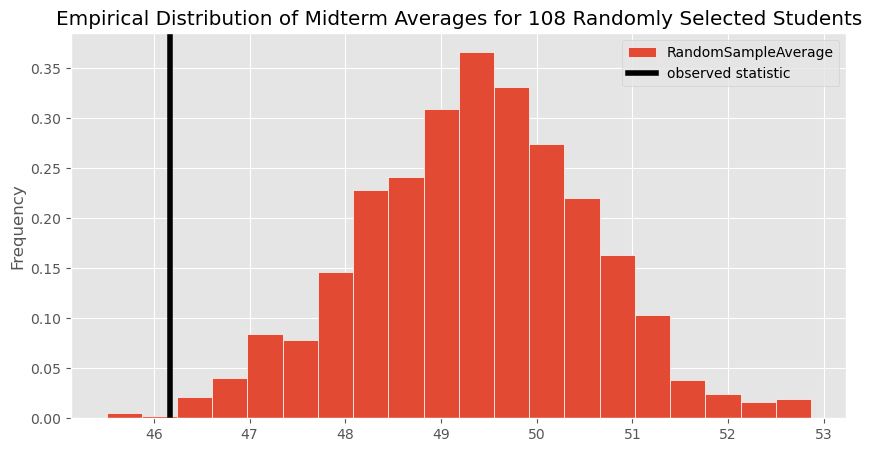

In [23]:
bpd.DataFrame().assign(RandomSampleAverage=averages).plot(kind='hist', bins=20, 
                                                          density=True, ec='w', figsize=(10, 5), 
                                                          title='Empirical Distribution of Midterm Averages for 108 Randomly Selected Students')
plt.axvline(observed_avg, color='black', linewidth=4, label='observed statistic')
plt.legend();

In [24]:
# p-value
np.count_nonzero(averages <= observed_avg) / repetitions

0.003

The p-value is below the standard cutoff of 0.05, and even below the 0.01 cutoff for being "highly statistically significant" so we **reject the null hypothesis.** It's not looking good for you, Suraj! 

## Comparing distributions

### Jury selection in Alameda County

<br>

<center><img src='images/aclu.png' width=500></center>

### Jury panels

Recall from Lecture 19:

<center>$\substack{\text{eligible} \\ \text{population}}
\xrightarrow{\substack{\text{representative} \\ \text{sample}}} 
\substack{\text{jury} \\ \text{panel}}
\xrightarrow{\substack{\text{selection by} \\ \text{judge/attorneys}}} 
\substack{\text{actual} \\ \text{jury}}$</center>

Section 197 of California's Code of Civil Procedure says, 
> "All persons selected for jury service shall be selected at random, from a source or sources inclusive of a representative cross section of the population of the area served by the court."

### Racial and Ethnic Disparities in Alameda County Jury Pools

- The American Civil Liberties Union (ACLU) of Northern California [studied](https://www.aclunc.org/sites/default/files/racial_and_ethnic_disparities_in_alameda_county_jury_pools.pdf) the ethnic composition of jury panels in 11 felony trials in Alameda County between 2009 and 2010.

- 1453 people reported for jury duty in total (we will call them "panelists").

- The following DataFrame shows the distribution in ethnicities for both the eligible population and for the panelists who were studied.

In [25]:
jury = bpd.DataFrame().assign(
    Ethnicity=['Asian', 'Black', 'Latino', 'White', 'Other'],
    Eligible=[0.15, 0.18, 0.12, 0.54, 0.01],
    Panels=[0.26, 0.08, 0.08, 0.54, 0.04]
)
jury

,Ethnicity,Eligible,Panels
0,Asian,0.15,0.26
1,Black,0.18,0.08
2,Latino,0.12,0.08
3,White,0.54,0.54
4,Other,0.01,0.04


What do you notice? 👀

### Are the differences in representation meaningful?

- **Null Hypothesis:** Panelists were selected at random from the eligible population.

- **Alternative Hypothesis:** Panelists were _not_ selected at random from the eligible population.

- Observation: 1453 panelists and the distribution of their ethnicities.

- Test statistic: ???
    - How do we deal with multiple categories?

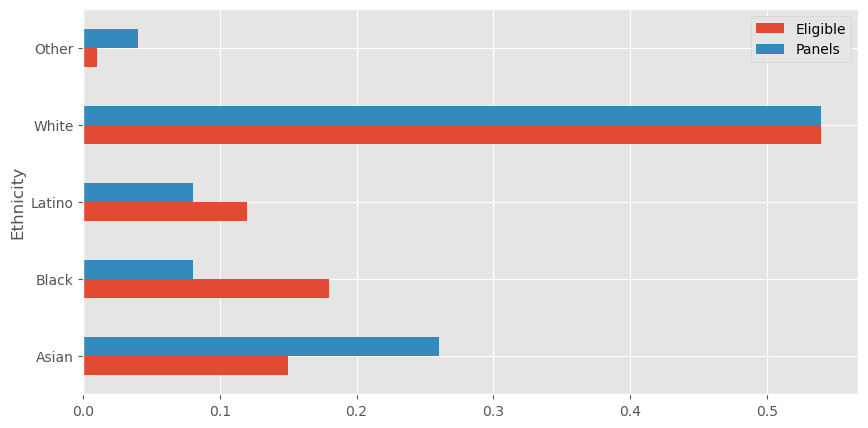

In [26]:
jury.plot(kind='barh', x='Ethnicity', figsize=(10, 5));

### The distance between two distributions

- Panelists are categorized into one of 5 ethnicities. In other words, ethnicity is a **categorical** variable.

- To see whether the the distribution of ethnicities for the panelists is similar to that of the eligible population, we have to measure the distance between two categorical distributions.
    - We've done this for distributions with just two categories – heads and tails, for instance – but not when there are more than two categories.

### The distance between two distributions

- Let's start by considering the difference in proportions for each category.

In [27]:
with_diffs = jury.assign(Difference=(jury.get('Panels') - jury.get('Eligible')))
with_diffs

,Ethnicity,Eligible,Panels,Difference
0,Asian,0.15,0.26,0.11
1,Black,0.18,0.08,-0.10
2,Latino,0.12,0.08,-0.04
3,White,0.54,0.54,0.00
4,Other,0.01,0.04,0.03


- Note that if we sum these differences, the result is 0 (you'll see the proof in DSC 40A).
- To avoid cancellation of positive and negative differences, we can take the absolute value of these differences.

In [28]:
with_abs_diffs = with_diffs.assign(AbsoluteDifference=np.abs(with_diffs.get('Difference')))
with_abs_diffs

,Ethnicity,Eligible,Panels,Difference,AbsoluteDifference
0,Asian,0.15,0.26,0.11,0.11
1,Black,0.18,0.08,-0.10,0.10
2,Latino,0.12,0.08,-0.04,0.04
3,White,0.54,0.54,0.00,0.00
4,Other,0.01,0.04,0.03,0.03


### Statistic: Total Variation Distance

The **Total Variation Distance (TVD)** of two categorical distributions is **the sum of the absolute differences of their proportions, all divided by 2**.

- We divide by 2 so that, for example, the distribution [0.51, 0.49] is 0.01 away from [0.50, 0.50].

- It would also be valid not to divide by 2. We just wouldn't call that statistic TVD anymore.

In [29]:
with_abs_diffs

,Ethnicity,Eligible,Panels,Difference,AbsoluteDifference
0,Asian,0.15,0.26,0.11,0.11
1,Black,0.18,0.08,-0.10,0.10
2,Latino,0.12,0.08,-0.04,0.04
3,White,0.54,0.54,0.00,0.00
4,Other,0.01,0.04,0.03,0.03


In [30]:
with_abs_diffs.get('AbsoluteDifference').sum() / 2

0.14

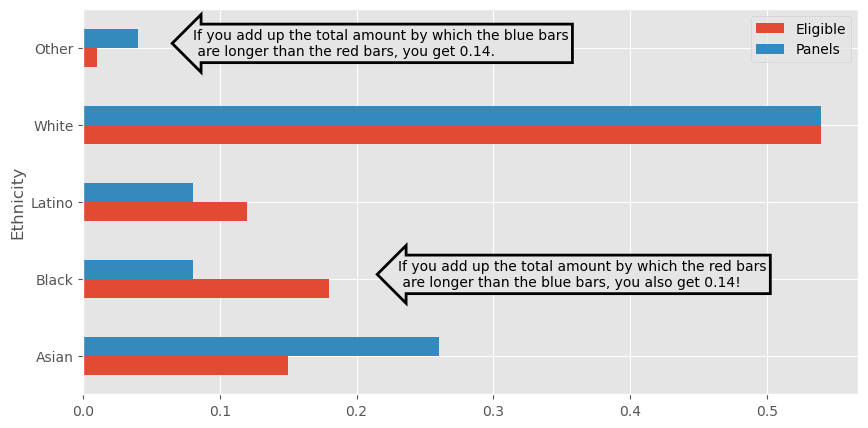

In [31]:
def total_variation_distance(dist1, dist2):
    '''Computes the TVD between two categorical distributions, 
       assuming the categories appear in the same order.'''
    return np.abs((dist1 - dist2)).sum() / 2

jury.plot(kind='barh', x='Ethnicity', figsize=(10, 5))
plt.annotate('If you add up the total amount by which the blue bars\n are longer than the red bars, you get 0.14.', (0.08, 3.9), bbox=dict(boxstyle="larrow,pad=0.3", fc="#e5e5e5", ec="black", lw=2));
plt.annotate('If you add up the total amount by which the red bars\n are longer than the blue bars, you also get 0.14!', (0.23, 0.9), bbox=dict(boxstyle="larrow,pad=0.3", fc="#e5e5e5", ec="black", lw=2));

- TVD quantifies the **total overrepresentation** across all categories. 
    - Equivalently, it also quantifies total underrepresentation across all categories.

### Concept Check ✅ – Answer at [cc.dsc10.com](http://cc.dsc10.com) 

What is the TVD between the distributions of class standing in DSC 10 and DSC 40A?

| **Class Standing** | **DSC 10** | **DSC 40A** |
| --- | --- | --- |
| Freshman | 0.45 | 0.15 |
| Sophomore | 0.35 | 0.35 |
| Junior | 0.15 | 0.35 |
| Senior+ | 0.05 | 0.15 |

- A. 0.2
- B. 0.3
- C. 0.5
- D. 0.6
- E. None of the above

### Simulate drawing jury panels

- Model: Panels are drawn at from the eligible population.

- Statistic: TVD between the random panel's ethnicity distribution and the eligible population's ethnicity distribution.

- Repeat many times to generate many TVDs, and see where the TVD of the observed panelists lies.

_Note_: `np.random.multinomial` creates samples drawn with replacement, even though real jury panels would be drawn without replacement. However, when the sample size (1453) is small relative to the population (number of people in Alameda County), the resulting distributions will be roughly the same whether we sample with or without replacement.

### The simulation

In [32]:
eligible = jury.get('Eligible')
sample_distribution = np.random.multinomial(1453, eligible) / 1453 
sample_distribution

array([0.15, 0.19, 0.13, 0.53, 0.01])

In [33]:
total_variation_distance(sample_distribution, eligible)

0.013833448038540953

### Repeating the experiment

In [34]:
tvds = np.array([])
repetitions = 10000
for i in np.arange(repetitions):
    sample_distribution = np.random.multinomial(1453, eligible) / 1453
    new_tvd = total_variation_distance(sample_distribution, eligible)
    tvds = np.append(tvds, new_tvd)

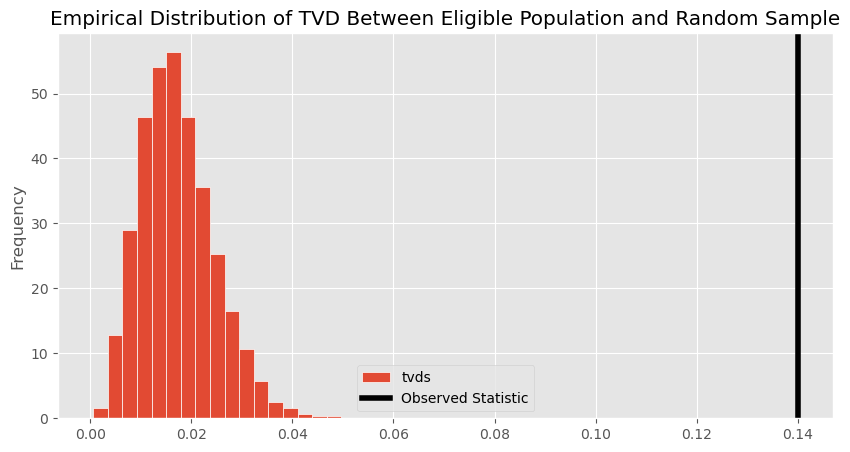

In [35]:
observed_tvd = total_variation_distance(jury.get('Panels'), eligible)

bpd.DataFrame().assign(tvds=tvds).plot(kind='hist', density=True, bins=20, ec='w', figsize=(10, 5),
                                      title='Empirical Distribution of TVD Between Eligible Population and Random Sample')
plt.axvline(observed_tvd, color='black', linewidth=4, label='Observed Statistic')
plt.legend();

### Calculating the p-value

In [36]:
np.count_nonzero(tvds >= observed_tvd) / repetitions

0.0

- Random samples from the eligible population are typically **much more similar** to the eligible population than our observed data. 
- We see this in the empirical distribution, which consists of **small TVDs** (much smaller than our observed TVD).

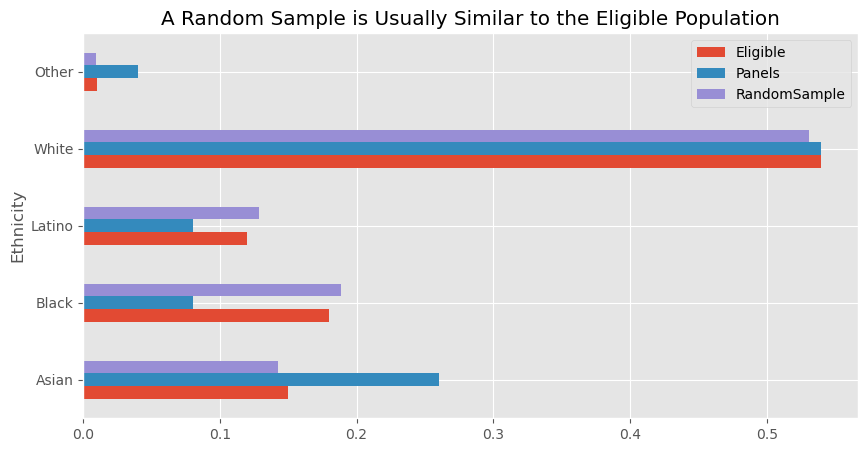

In [37]:
jury.assign(RandomSample=sample_distribution).plot(kind='barh', x='Ethnicity', figsize=(10, 5),
                                                   title = "A Random Sample is Usually Similar to the Eligible Population");

### Are the jury panels representative?

- Likely not! The distributions of ethnicities in our random samples are not like the distribution of ethnicities in our observed panelists.

- This doesn't say *why* the distributions are different!
    - Juries are drawn from voter registration lists and DMV records. Certain populations are less likely to be registered to vote or have a driver's license due to historical biases.
    - The county rarely enacts penalties for those who don't appear for jury duty; certain populations are less likely to be able to miss work to appear for jury duty.
    - [See the report](https://www.aclunc.org/sites/default/files/racial_and_ethnic_disparities_in_alameda_county_jury_pools.pdf) for more reasons.

## Summary, next time

### The hypothesis testing "recipe"

1. **State hypotheses**: State the null and alternative hypotheses. We must be able to simulate data under the null hypothesis.
1. **Choose test statistic**: Choose something that allows you to distinguish between the two hypotheses based on whether its value is high or low.
1. **Simulate**: Draw samples under the null hypothesis, and calculate the test statistic on each one.
1. **Visualize**: Plot the simulated values of the test statistic in a histogram, and compare this to the observed statistic (black line).
1. **Calculate p-value**: Find the proportion of simulations for which the test statistic was at least as extreme as the one observed.

### Why does it matter?

- Hypothesis testing is used all the time to make decisions in science and business.
- Hypothesis testing quantifies how "weird" a result is.
    - Instead of saying, "I think that's unusual," people say, "This has a p-value of 0.001."
- Through simulation, we have the tools to estimate how _likely_ something is, without needing to know a ton about probability theory.

### Next time

- All our hypothesis tests so far have involved sampling from a known distribution. 
- How do we test whether two samples are from the same **unknown** distribution?